In [1]:
import numpy as np

import torch
import torch.nn as nn
import torch.nn.init as init
import torch.optim as optim
import torch.optim.lr_scheduler as lr_scheduler
import torch.utils.data as data
from torch.autograd import Variable

from torchvision.transforms import Compose, RandomCrop, ToTensor, Scale, RandomHorizontalFlip
    
from PIL import Image

import os

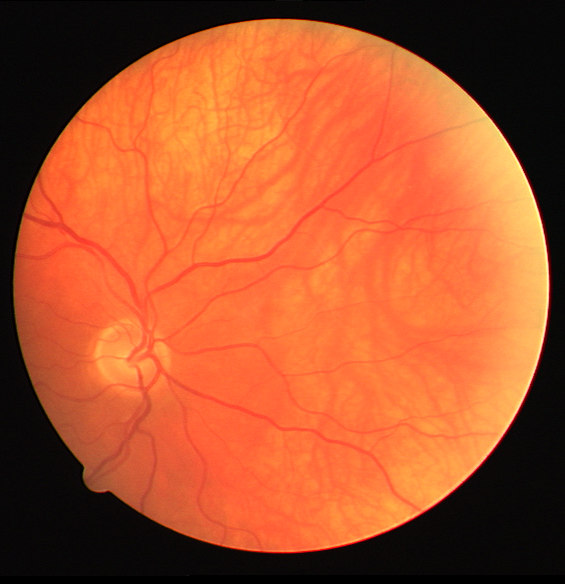

In [2]:
img = Image.open('/home/lukas/src/denoisingOphthalmology/data/raw/DRIVE/training/images/23_training.tif')
angles = np.array([0, 90, 180, 270])
img.rotate(np.random.choice(angles))

In [3]:
class RandomRotation(object):
    def __init__(self, angles=None):
        if angles:
            self.angles = angles
        else:
            self.angles = np.array([0, 90, 180, 270])

    @staticmethod
    def get_params(angles):
        angle = np.random.choice(angles)

        return angle

    def __call__(self, img):
        """
        Args:
            img (PIL Image): Image to be rotated.
        Returns:
            PIL Image: Rotated image.
        """

        angle = self.get_params(self.angles)

        return img.rotate(angle)

In [4]:
# See https://github.com/EdwardTyantov/LapSRN/blob/master/model.py etc.
# and https://github.com/BUPTLdy/Pytorch-LapSRN

In [5]:
# The util functions are stolen from 
#  https://warmspringwinds.github.io/tensorflow/tf-slim/2016/11/22/upsampling-and-image-segmentation-with-tensorflow-and-tf-slim/
# via https://github.com/EdwardTyantov/LapSRN,

def upsample_filter(size):
    """ 
    Create a 2D bilinear upsampling kernel for size (h,w)
    """
    factor = (size + 1)//2
    if size % 2 == 1:
        center = factor - 1
    else:
        center = factor - 0.5
    og = np.ogrid[:size, :size]
    return (1 - np.abs(og[0] - center) / factor) * \
           (1 - np.abs(og[1] - center) / factor)
    
def bilinear_upsample_matrix(filter_size, weights):
    """
    Generate weight matrix for bilinear upsampling with a transposed convolution.
    """
    filters_out = weights.size(0)
    filters_in = weights.size(1)
    weights = np.zeros((filters_out, filters_in, 4, 4), dtype=np.float32)
    
    kernel = upsample_filter(filter_size)
    
    for i in range(filters_out):
        for j in range(filters_in):
            weights[i, j, :, :] = kernel
    
    return torch.Tensor(weights)
    
class FeatureExtraction(nn.Module):
    def __init__(self, level, depth=3):
        super(FeatureExtraction, self).__init__()
        
        LReLu = nn.LeakyReLU(negative_slope=0.2)
        filters = nn.Sequential()
        
        # First layer is connected to input image, we only use Y color channel!
        if level == 0:
            filters.add_module(f'conv_input', nn.Conv2d(1, 64, 3, stride=1, padding=1))
            filters.add_module(f'lrelu_input', LReLu)
        # TODO: Maybe we drop a layer here, double check!    

        for i in range(depth):
            filters.add_module(f'conv{i}', nn.Conv2d(64, 64, 3, stride=1, padding=1))
            filters.add_module(f'lrelu{i}', LReLu)                               

        filters.add_module('convt_upsample', nn.ConvTranspose2d(64, 64, 4, stride=2, padding=1))
        filters.add_module('lrelu_upsame', LReLu)                   
        
        self.seq = filters
        
        # Init weights
        #self.seq[-2].weight.data.copy_(bilinear_upsample_matrix(4, self.seq[-2].weight))
        
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                init.kaiming_uniform(m.weight, a=0.2)
            if isinstance(m, nn.ConvTranspose2d):
                m.weight.data.copy_(bilinear_upsample_matrix(4, m.weight.data))
        
    def forward(self, x):
        out = self.seq(x)
        return out
    
class ImageReconstruction(nn.Module):
    def __init__(self):
        super(ImageReconstruction, self).__init__()
        self.conv_residual = nn.Conv2d(64, 1, 3, stride=1, padding=1) # last filter -> res
        self.upsample = nn.ConvTranspose2d(1, 1, 4, stride=2, padding=1)

        self.upsample.weight.data.copy_(bilinear_upsample_matrix(4, self.upsample.weight))
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                init.kaiming_normal(m.weight, a=0.2)
            if isinstance(m, nn.ConvTranspose2d):
                m.weight.data.copy_(bilinear_upsample_matrix(4, m.weight.data))
        
    def forward(self, lr_image, hr_filter):
        upsampled = self.upsample(lr_image)
        residual = self.conv_residual(hr_filter)
        return upsampled + residual
    
class LapSRN(nn.Module):
    def __init__(self, upsampling_factor=4, depth=5):
        super(LapSRN, self).__init__()
        
        # TODO: Don't ignore this!
        n_layers = np.log2(upsampling_factor).astype(np.int32)
        
        # Pytorch doesn't consider layers stored in a list.
        # See: https://discuss.pytorch.org/t/list-of-nn-module-in-a-nn-module/219
        # As a work-around create layers for 8x-upsampling and ignore unneeded layers
        
        # TODO: Use http://pytorch.org/docs/0.3.0/nn.html#modulelist
        self.feature_extraction0 = FeatureExtraction(level=0, depth=depth)
        self.feature_extraction1 = FeatureExtraction(level=1, depth=depth)
        self.feature_extraction2 = FeatureExtraction(level=2, depth=depth)
        
        self.image_reconstruction0 = ImageReconstruction()
        self.image_reconstruction1 = ImageReconstruction()
        self.image_reconstruction2 = ImageReconstruction()

    def forward(self, image):
        features0 = self.feature_extraction0(image)
        hr2 = self.image_reconstruction0(image, features0)
        
        features1 = self.feature_extraction1(features0)
        hr4 = self.image_reconstruction1(hr2, features1) 
      
        features2 = self.feature_extraction2(features1)
        hr8 = self.image_reconstruction2(hr4, features2)

        return hr2, hr4, hr8

In [6]:
LapSRN()

LapSRN(
  (feature_extraction0): FeatureExtraction(
    (seq): Sequential(
      (conv_input): Conv2d (1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (lrelu_input): LeakyReLU(0.2)
      (conv0): Conv2d (64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (lrelu0): LeakyReLU(0.2)
      (conv1): Conv2d (64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (lrelu1): LeakyReLU(0.2)
      (conv2): Conv2d (64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (lrelu2): LeakyReLU(0.2)
      (conv3): Conv2d (64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (lrelu3): LeakyReLU(0.2)
      (conv4): Conv2d (64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (lrelu4): LeakyReLU(0.2)
      (convt_upsample): ConvTranspose2d (64, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (lrelu_upsame): LeakyReLU(0.2)
    )
  )
  (feature_extraction1): FeatureExtraction(
    (seq): Sequential(
      (conv0): Conv2d (6

In [7]:
def load_image(path):
    # We only use the Y channel for the upscaling.
    img = Image.open(path).convert('YCbCr')
    return img.split()[0]

id_ = lambda x: x

class Dataset(data.Dataset):
    def __init__(self, path, hr_transform=id_, lr_transforms=[id_,]*3):
        super(Dataset, self).__init__
        
        self.hr_transform = hr_transform
        self.lr_transforms = lr_transforms
        
        image_suffixes = ['jpg', 'tif', 'ppm']        
        full_filename = lambda f: os.path.abspath(os.path.join(path, f))
        is_image = lambda f: any([f.endswith(f'{suff}') for suff in image_suffixes])
        
        self.filenames = [full_filename(f) for f in os.listdir(path) if is_image(f)]
        
    def __len__(self):
        return len(self.filenames)
    
    def __getitem__(self, idx):
        img = load_image(self.filenames[idx])
        
        # Compute all transformations for the downscaled versions.
        hr = self.hr_transform(img)
        lrs = [lr_transform(hr) for lr_transform in self.lr_transforms]
        
        to_tensor = ToTensor()
        tensors = [to_tensor(i) for i in (lrs + [hr])]
        # lr, hr2, hr4, hr8 = ...
        # shape for crops of size 100: 12, 25, 50, 100
        return tensors
    
def get_hr_transform(crop_size):
    return Compose([
        RandomCrop(crop_size),
        # RandomScale between 0.5 and 1.0
        RandomRotation(),
        RandomHorizontalFlip()
        # RandomVerticalFlip
    ])

def get_lr_transform(crop_size, factor):
    # Factor = 2 for hr4, Factor = 4 for hr2
    return Scale(crop_size//factor)

# ALL IMAGES ARE TRANSFORMED BY: 1) Rand. scaling between 0.5 and 1.0
# 2) Rotation by 90, 180, 270° 3) Flip img. hor./vert with prob of 0.5

In [8]:
class CharbonnierLoss(nn.Module):
    def __init__(self, eps=1e-6):
        """
        Eps is a relaxation parameter, the paper sets it to 1e-3.
        """
        super(CharbonnierLoss, self).__init__()
        self.eps = eps
        
    def forward(self, x, y):
        d = torch.add(x, -y)
        e = torch.sqrt(d**2 + self.eps)
        return torch.mean(e)

In [9]:
def save_checkpoint(epoch, model, optimizer, filename):
    state = {
        'epoch': epoch + 1,
        'model_state': model.state_dict(),
        'optim_state': optimizer.state_dict(),
    }
    torch.save(state, filename)

def train(criterion, train_data):
    cum_loss = 0.0
    for it, batch in enumerate(train_data):
        lr, hr2, hr4, hr8 = [Variable(b).cuda(async=True) for b in batch]        
        hr2_hat, hr4_hat, hr8_hat = model(lr)
        
        error_1 = criterion(hr2_hat, hr2)
        error_2 = criterion(hr4_hat, hr4)
        error_3 = criterion(hr8_hat, hr8)        
        loss = error_1 + error_2 + error_3 
        cum_loss += loss.data[0]
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if it > 0 and it % 10 == 0:
            print(f"Epoch={epoch}, Batch={it}/{len(train_data)}, Avg. loss = {cum_loss/it}")
 
def validate(validation_data):
    cum_psnr2, cum_psnr4, cum_psnr8 = 0.0, 0.0, 0.0
    
    for batch in validation_data:
        lr, hr2, hr4, hr8 = [Variable(b).cuda(async=True) for b in batch]
        hr2_hat, hr4_hat, hr8_hat = model(lr)
        
        mse = nn.MSELoss().cuda()
        error_1 = mse(hr2_hat, hr2)
        error_2 = mse(hr4_hat, hr4)
        error_3 = mse(hr8_hat, hr8)      
        
        get_psnr = lambda e: -10 * np.log10(e.data[0])
        # TODO: DELETE FOLLOWING LINE
        #get_psnr = lambda e: e.data[0]
        cum_psnr2 += get_psnr(error_1)
        cum_psnr4 += get_psnr(error_2)
        cum_psnr8 += get_psnr(error_3)
        
    print(f"Avg. PSNR: {cum_psnr2/len(validation_data)}, {cum_psnr4/len(validation_data)},{cum_psnr8/len(validation_data)}.")
    
CROP_SIZE = 128 # maybe 256?
hr_transform = get_hr_transform(CROP_SIZE)
lr_transforms = [get_lr_transform(CROP_SIZE, factor) for factor in [8, 4, 2]]

train_dataset = Dataset("../../data/raw/all-images/", hr_transform=hr_transform, lr_transforms=lr_transforms)
train_data = data.DataLoader(dataset=train_dataset, num_workers=4, batch_size=16, shuffle=True, pin_memory=True)

validation_dataset = Dataset("../../data/raw/DRIVE/training/images", hr_transform=hr_transform, lr_transforms=lr_transforms)
validation_data = data.DataLoader(dataset=validation_dataset, num_workers=4, batch_size=4, shuffle=True, pin_memory=True)

model = LapSRN(upsampling_factor=8, depth=5).cuda()

criterion = CharbonnierLoss().cuda()

optimizer = optim.Adam(model.parameters(), weight_decay=1e-4)
scheduler = lr_scheduler.StepLR(optimizer, step_size=50, gamma=0.5) # See paper

continue_training = True
if continue_training:
    checkpoint = torch.load("../../checkpoints/srn_1600.pt")
    model.load_state_dict(checkpoint['model_state'])
    optimizer.load_state_dict(checkpoint['optim_state'])
    epoch = checkpoint['epoch']
    validate(validation_data)


num_epochs = 0
checkpoint_every = 100

for epoch in range(epoch, num_epochs+1):
    print(f"Started epoch num={epoch}.")   
    scheduler.step()
    train(criterion, train_data)
    validate(validation_data)
    
    checkpoint_name = f'../../checkpoints/srn_{epoch}.pt'
    
    if (epoch % checkpoint_every) == 0:
        save_checkpoint(epoch, model, optimizer, checkpoint_name)


/home/lukas/bin/anaconda3/lib/python3.6/site-packages/torchvision-0.2.0-py3.6.egg/torchvision/transforms/transforms.py:156: UserWarning: The use of the transforms.Scale transform is deprecated, please use transforms.Resize instead.


Avg. PSNR: 35.500293586802925, 33.16325237939264,31.334033429253463.


In [10]:
img_path = '../../data/raw/DRIVE/test/images/04_test.tif'
img = Image.open(img_path).convert('YCbCr').resize((250,250))
y, cb, cr = img.split()
to_tensor = ToTensor()
y = to_tensor(y)
#img = img.resize(((200, 200)))

In [12]:
idx = 1
out = model.cuda()(Variable(y).cuda().unsqueeze(0))
Y = out[idx].cpu().data.numpy().reshape(out[idx].size(2), -1)
Y = (Y * 255).clip(0, 255) # Clip avoids noise in some areas!
Y = Image.fromarray(np.uint8(Y), mode='L')
CB = cb.resize(Y.size, Image.BICUBIC)
R = cr.resize(Y.size, Image.BICUBIC)
out_rgb = Image.merge('YCbCr', [Y, CB, R])
out[idx]

Variable containing:
( 0  , 0  ,.,.) = 
  9.7622e-02  8.7147e-02  7.4666e-02  ...   5.8354e-02  6.4260e-02  7.5471e-02
  6.7829e-02  1.9369e-02  3.5794e-03  ...   3.2426e-02  3.5758e-02  6.1285e-02
  5.3774e-02 -1.1547e-02 -3.0094e-02  ...   2.1126e-02  2.9190e-02  4.7617e-02
                 ...                   ⋱                   ...                
  5.8025e-02  1.3113e-02 -6.7191e-04  ...   3.1161e-02  3.4534e-02  6.8846e-02
  5.2261e-02  1.0205e-02 -1.8987e-03  ...   6.0824e-02  8.6108e-02  1.0421e-01
  4.6095e-02  2.0050e-02  2.5173e-02  ...   1.2021e-01  1.2757e-01  1.1667e-01
[torch.cuda.FloatTensor of size 1x1x1000x1000 (GPU 0)]

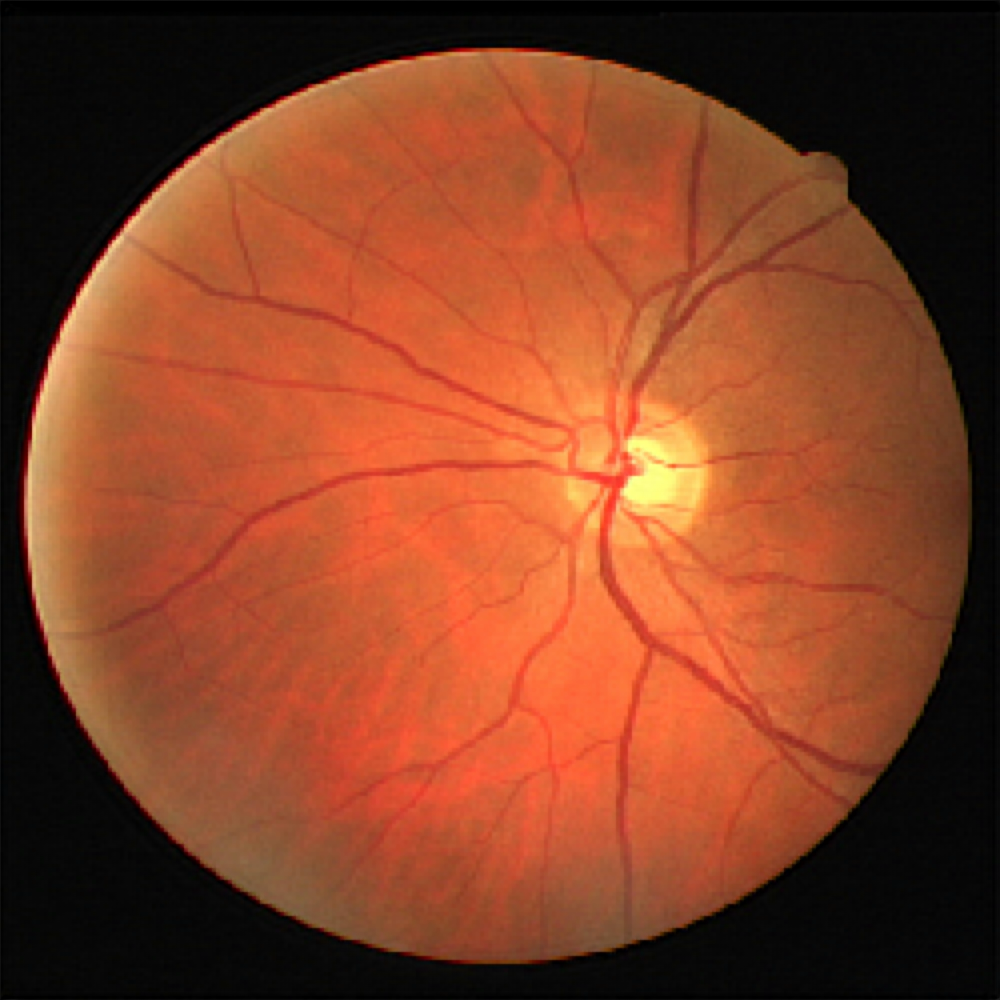

In [13]:
out_rgb.convert('RGB') # todo add other channels

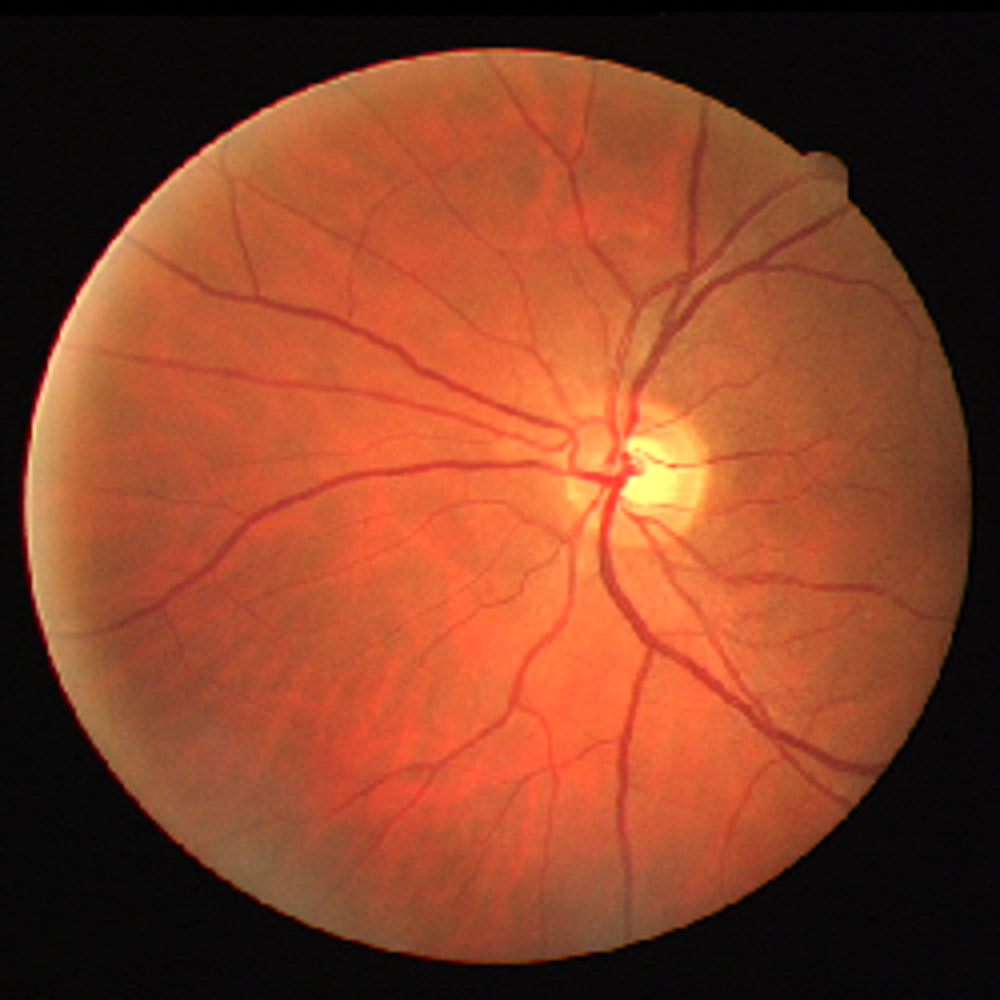

In [16]:
Image.open(img_path).resize((250,250)).resize((1000,1000), \
                                Image.BICUBIC)

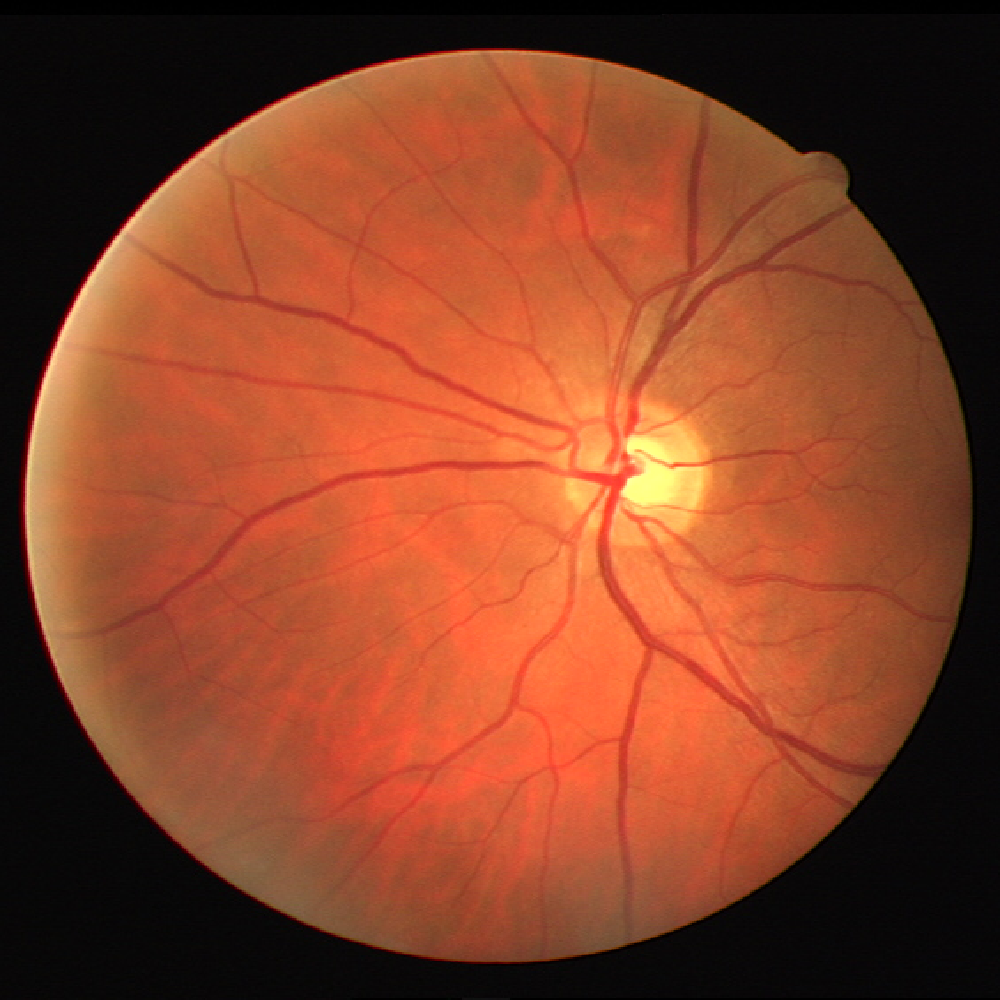

In [15]:
Image.open(img_path).resize((1000,1000))